# Exploratory Data Analysis: coffee leaf

In [29]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from PIL import Image, UnidentifiedImageError

image_dataset_path = './dataset/Photos'
image_classification_path = "./dataset/RoCoLe-classes.xlsx"

all_image_files = [f for f in os.listdir(image_dataset_path) if f.lower().endswith(('.jpg', '.png'))]

print(f"Total images in dataset: {len(all_image_files)}")


Total images in dataset: 1560


#### Check for images integrity
The check for images integrity, will check for corrupt files, such as images that cannot be open.
Then, it returns the corrupt file when found and remove this file from bytecode array.

In [30]:

corrupted_images = []

for img_file in all_image_files:
    img_path = os.path.join(image_dataset_path, img_file)

    try:
        with Image.open(img_path) as img:
            img.verify()
    except (UnidentifiedImageError, IOError):
        corrupted_images.append(img_file)

if corrupted_images:
    print(f"Found {len(corrupted_images)} corrupted images:")
    for img in corrupted_images:
        print(img)
else:
    print("No corrupted images found!")

for img_file in corrupted_images:
    os.remove(os.path.join(image_dataset_path, img_file))
    print(f"Deleted corrupted file: {img_file}")


No corrupted images found!


### Check for images saturation
Brightness variations can bias a model if lighting conditions differ between classes. Analyzing brightness distribution helps detect overexposed or underexposed images ensuring balanced training data.
- A bell-shaped histogram suggests a well-balanced brightness distribution, meaning no major adjustments are needed.
- A left-skewed histogram indicates that many images are too dark, which may require brightness normalization.
- A right-skewed histogram suggests that many images are too bright, which may require contrast adjustments.


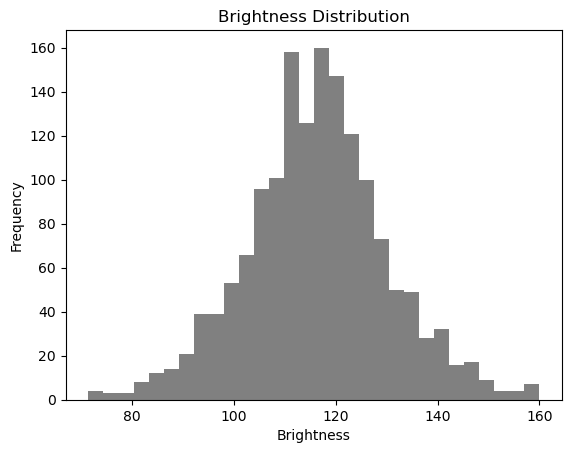

In [31]:
def compute_brightness(image):
    return np.mean(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))  # Convert to grayscale & compute mean

brightness_values = [compute_brightness(cv2.imread(os.path.join(image_dataset_path, img_file)))
                     for img_file in all_image_files if cv2.imread(os.path.join(image_dataset_path, img_file)) is not None]

plt.hist(brightness_values, bins=30, color='gray')
plt.title("Brightness Distribution")
plt.xlabel("Brightness")
plt.ylabel("Frequency")
plt.show()


#### Check for blurry images
Blurry images can negatively impact model performance by reducing the clarity of important features. The variance of the Laplacian method detects image sharpness by measuring edge strength. A higher variance indicates a sharper image, while a lower variance suggests blurriness.
- A wide, evenly spread distribution suggests a mix of sharp and blurry images.
- A left-skewed histogram (many low variance values) indicates that a significant number of images are blurry, which may require filtering or sharpening.
- A right-skewed histogram (mostly high variance values) suggests that most images are sharp, and no correction is needed.

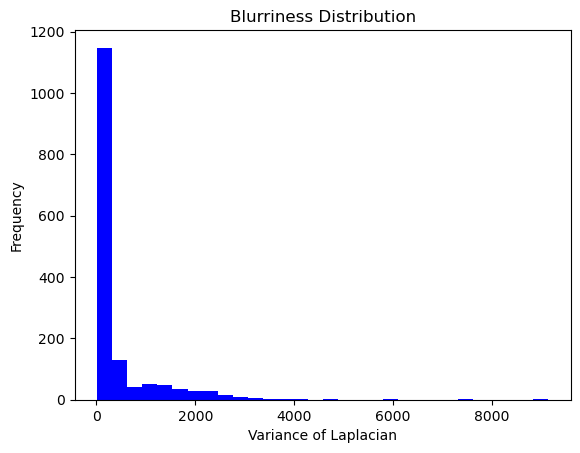

In [32]:
def variance_of_laplacian(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()  # Compute Laplacian variance

blur_scores = [variance_of_laplacian(cv2.imread(os.path.join(image_dataset_path, img_file), cv2.IMREAD_GRAYSCALE))
               for img_file in all_image_files if cv2.imread(os.path.join(image_dataset_path, img_file)) is not None]

plt.hist(blur_scores, bins=30, color='blue')
plt.title("Blurriness Distribution")
plt.xlabel("Variance of Laplacian")
plt.ylabel("Frequency")
plt.show()


#### Color Distribution
Analyzing the distribution of color intensities helps identify potential biases in the dataset. If one class of images consistently has a dominant color, the model may learn color patterns instead of meaningful features. This analysis extracts the average intensity of the red (R), green (G), and blue (B) channels across all images.
- Balanced distributions across all three channels suggest a diverse dataset with varied colors, which is ideal for generalization
- A dominant peak in one channel (e.g., a strong red peak) may indicate a color bias, possibly due to lighting conditions or object characteristics.
- A skewed distribution in a specific channel could suggest an imbalance in the dataset, which may need color normalization or augmentation to improve model robustness.


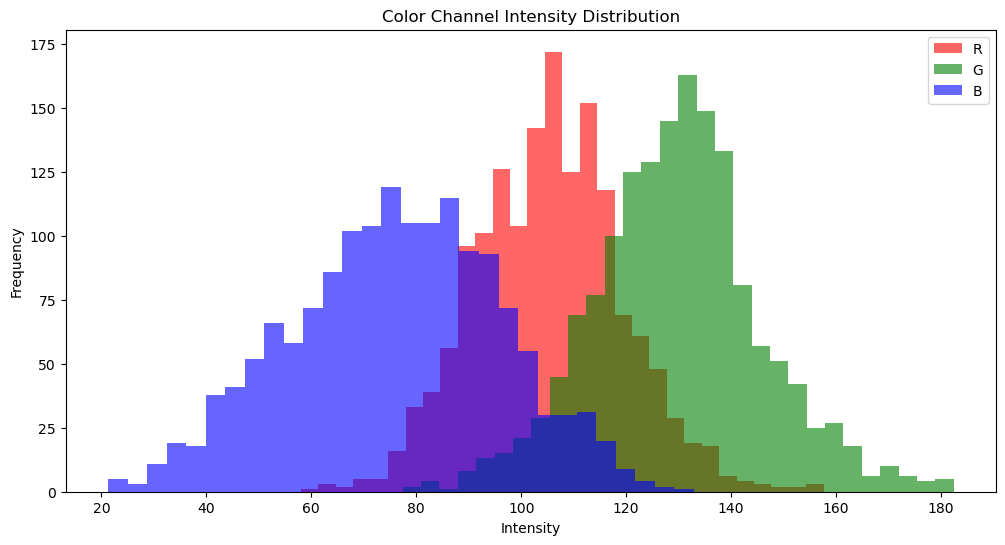

In [33]:
means = {'R': [], 'G': [], 'B': []}

for img_file in all_image_files:
    img = cv2.imread(os.path.join(image_dataset_path, img_file))
    if img is not None:
        b, g, r = cv2.mean(img)[:3]  # Extract mean BGR values
        means['B'].append(b)
        means['G'].append(g)
        means['R'].append(r)

plt.figure(figsize=(12, 6))
for color in ['R', 'G', 'B']:
    plt.hist(means[color], bins=30, alpha=0.6, label=color, color=color.lower())
plt.title("Color Channel Intensity Distribution")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.show()


#### Preprocessing before training

In [27]:
df = pd.read_excel(image_classification_path)

healthy_filenames = df[df["Binary.Label"] == "healthy"]["File"].tolist()
unhealthy_filenames = df[df["Binary.Label"] == "unhealthy"]["File"].tolist()

print(f"Total healthy coffee leaf images in dataset: {len(healthy_filenames)}")
print(f"Total unhealthy coffee leaf images in dataset: {len(unhealthy_filenames)}")

def create_image_array(filename_list, target_size=(128, 128)):
    image_array = []

    for file in filename_list:
        path = os.path.join(image_dataset_path, file)
        img_bytes = cv2.imread(path)
        if img_bytes is None:
            print('Could not read the image, file skipped: {file}')
            continue

        img_bytes = cv2.resize(img_bytes, target_size)
        img_bytes = img_bytes.flatten()
        image_array.append(img_bytes)

    return image_array

healthy_images = create_image_array(healthy_filenames)
unhealthy_images = create_image_array(unhealthy_filenames)

Total healthy coffee leaf images in dataset: 791
Total unhealthy coffee leaf images in dataset: 769


#### Model training using SVC and RandomForest

In [28]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
import numpy as np

# Convert images to NumPy arrays
healthy_images_np = np.array(healthy_images)
unhealthy_images_np = np.array(unhealthy_images)

# Stack images and create labels
X = np.vstack((healthy_images_np, unhealthy_images_np))
y = np.array([0] * len(healthy_images_np) + [1] * len(unhealthy_images_np))  # 0 = Healthy, 1 = Unhealthy

# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define SVC parameter grid
svc_param_grid = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", "auto"]
}
svc_grid = GridSearchCV(SVC(), svc_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)

# Define Random Forest parameter grid
rf_param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, 20]
}
rf_grid = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)

# Train SVC
print("Training SVC...")
svc_grid.fit(X_train, y_train)
best_svc_model = svc_grid.best_estimator_
y_pred_svc = best_svc_model.predict(X_test)

# Train Random Forest
print("Training Random Forest...")
rf_grid.fit(X_train, y_train)
best_rf_model = rf_grid.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate models
svc_report = classification_report(y_test, y_pred_svc, target_names=["Healthy", "Unhealthy"])
rf_report = classification_report(y_test, y_pred_rf, target_names=["Healthy", "Unhealthy"])

# Print results
print(f" Best SVC Parameters: {svc_grid.best_params_}")
print(f" SVC Classification Report:\n{svc_report}")

print(f" Best RF Parameters: {rf_grid.best_params_}")
print(f" Random Forest Classification Report:\n{rf_report}")


Training SVC...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Training Random Forest...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
 Best SVC Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
 SVC Classification Report:
              precision    recall  f1-score   support

     Healthy       0.68      0.61      0.65       171
   Unhealthy       0.58      0.65      0.62       141

    accuracy                           0.63       312
   macro avg       0.63      0.63      0.63       312
weighted avg       0.64      0.63      0.63       312

 Best RF Parameters: {'max_depth': 10, 'n_estimators': 200}
 Random Forest Classification Report:
              precision    recall  f1-score   support

     Healthy       0.68      0.67      0.68       171
   Unhealthy       0.61      0.62      0.61       141

    accuracy                           0.65       312
   macro avg       0.64      0.64      0.64       312
weighted avg       0.65      0.65      0.65  